In [1]:
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from numpy.typing import NDArray
from plot_shift.profit_based_thresholds_plot import (
    calculate_profit_thresholds,
    plot_profit_thresholds,
)
from tabulate import tabulate
from xgboost import XGBClassifier

from sklearn.calibration import calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import (
    LearningCurveDisplay,
    GridSearchCV,
    TimeSeriesSplit,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from mads_telemarketing_assignment.config import (
    DATA_FILENAME,
    PROCESSED_DATA_DIR,
)

In [2]:
# Various variables used in the code
random_state = 42

In [3]:
# Load  processed dataset
df = pd.read_csv(PROCESSED_DATA_DIR / DATA_FILENAME)

In [4]:
# Define X and y for modeling
X = df.drop(columns=["y"], axis=1)
y = df["y"]

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (1333, 16), y shape: (1333,)


In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=random_state,
    shuffle=False,
    test_size=0.2,  # 20% of the data for testing
)

# Convert to numpy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [6]:
# Transform features to prepare for modelling
transformer = ColumnTransformer(
    [
        (
            "categorical",
            OneHotEncoder(
                sparse_output=False,
                handle_unknown="ignore",
            ),
            [
                "contact",
                "day_of_week",
                "default",
                "education",
                "housing",
                "job",
                "loan",
                "marital",
                "month",
            ],
        ),
    ],
    remainder=MinMaxScaler(),
)
X_train_transformed = transformer.fit_transform(X_train)

In [7]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=random_state)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

print(f"X_train_balanced shape: {X_train_balanced.shape}, y_train_balanced shape: {y_train_balanced.shape}")

X_train_balanced shape: (1246, 51), y_train_balanced shape: (1246,)


In [8]:
# Define time series splitter for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [9]:
# Define function to calculate maximum profit
def calculate_maximum_profit(
    y_true: NDArray[np.int32],
    y_probs: NDArray[np.float32],
) -> int:
    # Calculate various metrics based on the binary classifier curve
    results = calculate_profit_thresholds(y_true, y_probs)
    # Return the maximum profit as the score
    return results[2]


# Define scorer for maximum profit calculation
maximum_profit_scorer = make_scorer(
    calculate_maximum_profit,
    response_method="predict_proba",
    greater_is_better=True,
)

In [10]:
# Define list of classifiers to be used in modeling process
classifiers = {
    "AdaBoost": [
        AdaBoostClassifier(random_state=random_state),
        {
            # "learning_rate": [0.01],
        },
    ],
    "Gradient Boosting": [
        GradientBoostingClassifier(random_state=random_state),
        {
            # "n_estimators": [100, 200, 300],
            # "learning_rate": [0.1, 0.01, 0.001],
            # "max_depth": [3, 5, 7],
        },
    ],
    "K-Nearest Neighbors": [
        KNeighborsClassifier(n_jobs=-1),
        {
            # "n_neighbors": [3, 5, 7],
            # "weights": ["uniform", "distance"],
            # "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        },
    ],
    "Logistic Regression": [
        LogisticRegression(random_state=random_state),
        {
            # "penalty": ["l2", "none"],
            # "C": [0.1, 1.0, 10.0],
            # "solver": ["lbfgs", "liblinear"],
        },
    ],
    "Random Forest": [
        RandomForestClassifier(random_state=random_state),
        {
            # "n_estimators": [100, 200, 300],
            # "max_depth": [10, 20, 30],
            # "min_samples_split": [2, 5, 10],
            # "min_samples_leaf": [1, 2, 4],
        },
    ],
    "XGBoost": [
        XGBClassifier(random_state=random_state),
        {
            # "n_estimators": [100, 200, 300],
            # "learning_rate": [0.1, 0.01, 0.001],
            # "max_depth": [3, 5, 7],
        },
    ],
}

In [11]:
print("Start hypertuning:")

# Loop through each classifier and perform grid search for hyperparameter tuning
for name, (classifier, param_grid) in classifiers.items():
    print(f"- {name}")

    grid_search = GridSearchCV(
        cv=tscv,
        estimator=classifier,
        n_jobs=-1,
        param_grid=param_grid,
        scoring=maximum_profit_scorer,
    )
    grid_search.fit(X_train_balanced, y_train_balanced)
    # Overwrite the classifier with the best found parameters
    classifiers[name] = [grid_search.best_estimator_, grid_search.best_params_]

print("✅ Hypertuning completed.")

# Print the results of the grid search
# print("\nGrid Search Results:")
# results = []
# for name, (estimator, params) in classifiers.items():

#     print(f"- {name} with parameters: {params}")
#     print(f"- Best score: {estimator.score(X_train_balanced, y_train_balanced)}")

Start hypertuning:
- AdaBoost
- Gradient Boosting
- K-Nearest Neighbors
- Logistic Regression
- Random Forest
- XGBoost
✅ Hypertuning completed.


In [12]:
# Define dictionary to store results of each classifier
from sklearn.model_selection import KFold


probabilities = {}
predictions = {}

print("Start modelling:")

# Loop through each classifier, fit, cross-validate and store results
for name, (classifier, _) in classifiers.items():
    print(f"- {name}")

    # Prepare an array to store predictions for all training samples
    y_prob = np.zeros(len(y_train_balanced))
    y_preds = np.zeros(len(y_train_balanced))

    for fold_train_index, fold_test_index in tscv.split(X_train_balanced, y_train_balanced):
        # Split the data into training and test folds
        X_fold_train, X_fold_test = (
            X_train_balanced[fold_train_index],
            X_train_balanced[fold_test_index],
        )
        y_fold_train, y_fold_test = (
            y_train_balanced[fold_train_index],
            y_train_balanced[fold_test_index],
        )
        # Fit the pipeline on the training fold
        classifier.fit(X_fold_train, y_fold_train)
        # Make and store probabilities and predictions for the test fold
        y_prob[fold_test_index] = classifier.predict_proba(X_fold_test)[:, 1]
        y_preds[fold_test_index] = classifier.predict(X_fold_test)

    probabilities[name] = y_prob
    predictions[name] = y_preds

print("✅ Modelling completed.")

Start modelling:
- AdaBoost
- Gradient Boosting
- K-Nearest Neighbors
- Logistic Regression
- Random Forest
- XGBoost
✅ Modelling completed.


ValueError: Found input variables with inconsistent numbers of samples: [1066, 1246]

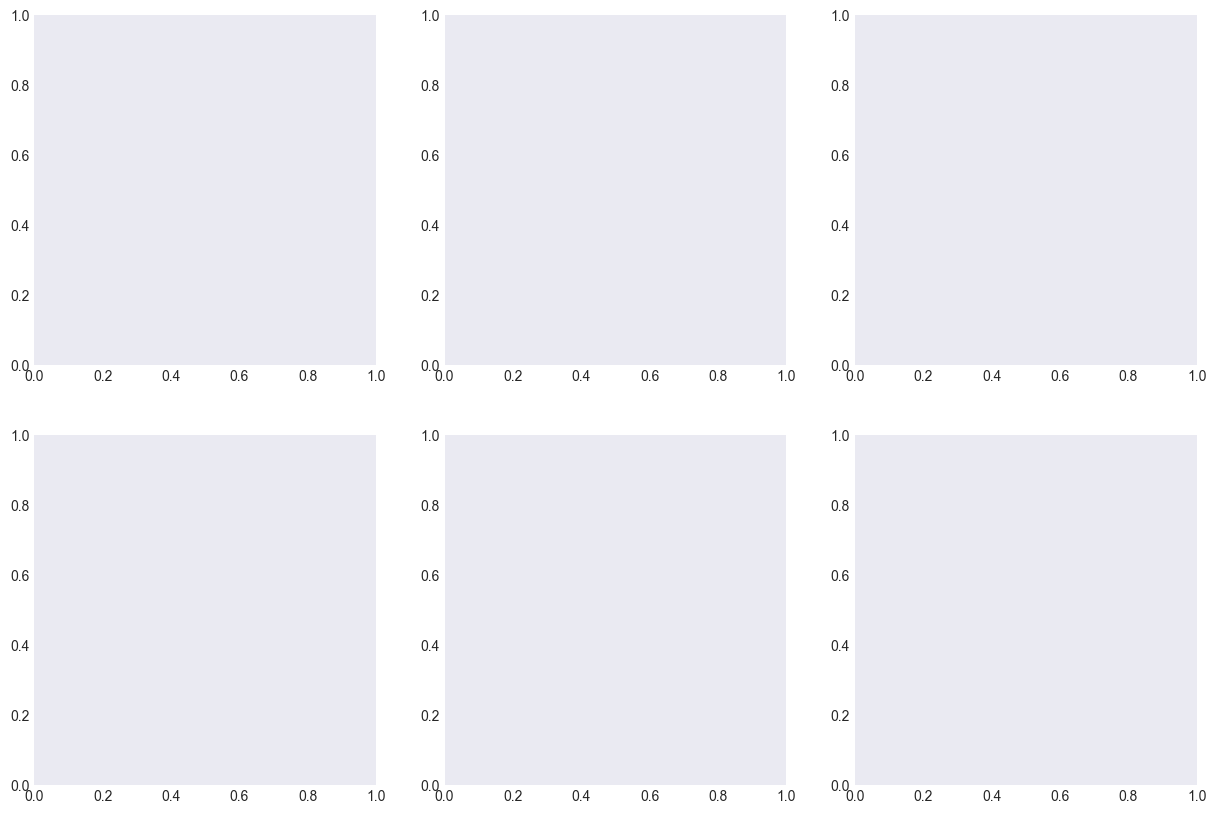

In [13]:
plt.style.use("seaborn-v0_8-dark")

_, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (model_name, y_pred) in zip(axes.flatten(), predictions.items()):
    ConfusionMatrixDisplay.from_predictions(
        y_train,
        y_pred,
        ax=ax,
        colorbar=False,
    )
    ax.set_title(model_name)

plt.tight_layout()
plt.show()

In [ ]:
plt.style.use("seaborn-v0_8-darkgrid")

plt.figure(figsize=(8, 8))

for model_name, y_prob in probabilities.items():
    prob_true, prob_pred = calibration_curve(y_train, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker="o", label=model_name, linewidth=2)

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Define dictionary to store metrics for each classifier
metrics = {}

# Calculate various metrics based on the results of the classifiers
for name, y_prob in probabilities.items():
    # Calculate profit thresholds and metrics
    metrics[name] = calculate_profit_thresholds(y_train, y_prob)

In [ ]:
_, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (name, metric) in zip(axes.flatten(), metrics.items()):
    (
        thresholds,
        profits,
        maximum_profit,
        optimal_threshold,
        precision,
        recall,
    ) = metric
    plot_profit_thresholds(
        profits,
        thresholds,
        optimal_threshold,
        ax=ax,
        model_name=name,
    )

In [ ]:
# Prepare headers and metrics for the table
headers = ["Metric"] + list(metrics.keys())

table = []
for name, metric in metrics.items():
    # Collect metrics for each model in a more elegant way
    values = [
        metric[2],  # Maximum Profit
        metric[3],  # Optimal Threshold
        metric[4],  # Precision
        metric[5],  # Recall
    ]
    if len(table) == 0:
        metric_names = [
            "Maximum Profit",
            "Optimal Threshold",
            "Precision",
            "Recall",
        ]
        table = [[name] for name in metric_names]
    for i, value in enumerate(values):
        if isinstance(value, float):
            table[i].append(f"{value:.3f}")
        else:
            table[i].append(f"{value:,}" if isinstance(value, int) else str(value))


print(tabulate(table, headers, tablefmt="github"))

In [ ]:
# Select classifier with highest maximum profit
selected_model_name = max(metrics.items(), key=lambda x: x[1][2])[0]
# Grab the best model based on the name
selected_model = classifiers[selected_model_name][0]

print(f"Selected model: {selected_model_name}")

In [ ]:
# Fit the selected model on the balanced training data
selected_model.fit(X_train_balanced, y_train_balanced)
# Predict probabilities on the test set
# Note: The transformer is used to transform the test set features
X_test_transformed = transformer.transform(X_test)
y_prob = selected_model.predict_proba(X_test_transformed)[:, 1]
y_pred = selected_model.predict(X_test_transformed)

In [ ]:
fig, ax = plt.subplots()

LearningCurveDisplay.from_estimator(
    selected_model,
    X_train_balanced,
    y_train_balanced,
    ax=ax,
)
ax.set_title(selected_model_name)

plt.tight_layout()
plt.show()

In [ ]:
plt.style.use("seaborn-v0_8-dark")

fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    ax=ax,
    colorbar=False,
)
ax.set_title(selected_model_name)

plt.tight_layout()
plt.show()

In [ ]:
plt.style.use("seaborn-v0_8-darkgrid")

plt.figure()

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker="o", label=selected_model_name, linewidth=2)

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
(
    thresholds,
    profits,
    maximum_profit,
    optimal_threshold,
    precision,
    recall,
) = calculate_profit_thresholds(y_test, y_prob)

fig, ax = plt.subplots(figsize=(10, 10))
plot_profit_thresholds(
    profits,
    thresholds,
    optimal_threshold,
    ax=ax,
    model_name=f"{selected_model_name} (Test Set)",
)
plt.show()

print("Maximum Profit", f"{maximum_profit:,}")
print("Optimal Threshold", f"{optimal_threshold:.3f}")
print("Precision", f"{precision:.3f}")
print("Recall", f"{recall:.3f}")